In [ ]:
################################################################################
## Motif Switching 
## Written by Soon Yi
## Created: 2024-05-23
## Last Edited: 2024-05-23
################################################################################

In [78]:
## Load libraries
################################################################################
import os
import pandas as pd
import numpy as np
import random
from scipy.stats import pearsonr, spearmanr, linregress
from scipy.integrate import trapz
from sympy import symbols, expand, collect, Poly
import matplotlib.pyplot as plt
import seaborn as sns
################################################################################

In [2]:
## Set basic parameters and functions:
################################################################################
baseDir = '~/Desktop/Genomics/Specificity/Data_Final/in_vitro_CLIP/'

pd.set_option('display.float_format', lambda x: '%.5f' % x)

def featureScale(X, MAX, MIN):
    if (MAX <= MIN):
        raise ValueError("MAX cannot be lower than or equal to MIN.")
    X = np.array(X)  
    X_min = np.nanmin(X)
    X_max = np.nanmax(X)
    return MIN + ((X - X_min) * (MAX - MIN)) / (X_max - X_min)

def processFASTA(PATH, NAME):
    ID = ''
    SEQ = ''
    
    # Read the FASTA file
    with open(os.path.expanduser(PATH + 'target_RNA/' + NAME + '.fa'), 'r') as f:
        for line in f:
            if line.startswith('>'):
                # Extract chromosome number and calculate length
                header_info = line.split(' ')[1]  # Get the first part of the header
                ID = header_info.split('=')[1].split(':')[0]  # Extract chromosome number
                start, end = map(int, header_info.split('=')[1].split(':')[1].split('-'))  # Extract start and end positions
            else:
                SEQ += line.strip()  # Add sequence
    
    LEN = len(SEQ)

    # Return the processed information
    return [ID, LEN, NAME, SEQ.replace('T', 'U')]

def generateRNA(L, A=0.25, G=0.25, C=0.25, U=0.25):
    
    if A + G + C + U != 1:
        raise ValueError("Input fractions A, G, C, and U must sum up to 1")

    NTs = {
        'A': A,
        'G': G,
        'C': C,
        'U': U
    }

    seq = [NT for NT, percentage in NTs.items() for _ in range(int(L * percentage))]
    random.shuffle(seq)
    seq = ''.join(seq)
    
    return seq

def allBind(N, x0, P0n_vals, Kn_vals):
    # N:        Number of RBP(s).
    # x0:       Initial concentration of RNA.
    # P0n_vals: List of initial protein concentrations.
    # Kn_vals:  List of Kd values for each protein.
    #
    # Here, we solve for equilibrium concentration of RNA, X.
    # X can be utilized to calculate equilibrium concentrations of RBPs. 

    import sympy as sp

    if (len(P0n_vals) != N):
        raise ValueError("Number of initial protein concentrations provided does not match number of proteins.")
    if (len(Kn_vals) != N):
        raise ValueError("Number of Kd values provided does not match number of proteins.")

    # Set up the symbols for the equation:
    X, x, n = sp.symbols('X x n', real=True)
    P0n = sp.symbols('P0n')
    Kn = sp.symbols('Kn')

    # Define the equation:
    eq = X - x + sp.Sum((P0n * X) / (Kn + X), (n, 1, N))

    # Expand the summation manually
    eq_expand = sp.Add(*[eq.subs({P0n: P0n_val, Kn: Kn_val}) for P0n_val, Kn_val in zip(P0n_vals, Kn_vals)])

    # Substitute the value of 'x'
    eq_subs_x = eq_expand.subs({x: x0})

    # Simplify step by step
    eq_collect = sp.collect(eq_subs_x, X)  # Collect X terms
    eq_simplify = sp.simplify(eq_collect)  # Simplify the expression

    eq_final = sp.simplify(eq_simplify)
    eq_final = sp.denom(eq_final) * eq_final

    X_roots = np.roots(sp.Poly(eq_final, X).all_coeffs())
    X_eq = X_roots[X_roots >= 0][X_roots[X_roots >= 0] <= x0][0]

    return X_eq


In [42]:
## Process RNACompete Data
################################################################################
RNCMPT_org = pd.read_table(baseDir + 'RNACompete/z_scores.txt')
RBP_List = pd.read_table(baseDir + 'RNACompete/rbp_list_2.txt')

RNCMPT = RNCMPT_org[['7mer'] + [col for col in RNCMPT_org.columns if col.endswith('_setAB')]]
RNCMPT.columns = ['Motif'] + [col.replace('_z_setAB', '') for col in RNCMPT.columns[1:]]
RNCMPT = RNCMPT[['Motif'] + list(RBP_List.RNACompete)]

RNCMPT_norm = RNCMPT
RNCMPT_norm.iloc[:, 1:] = RNCMPT_norm.iloc[:, 1:].apply(lambda x: featureScale(x, 1, 0))

duplicated = ['HNRNPL', 'MSI1', 'RBM4', 'RBM5', 'RBMS3', 'SRSF9', 'TIA1']

for choice in duplicated:
    RNCMPT_norm[choice] = RNCMPT_norm[RBP_List[RBP_List.RBP == choice].RNACompete].mean(axis = 1)
    RNCMPT_norm = RNCMPT_norm.drop(columns = RBP_List[RBP_List.RBP == choice].RNACompete)

RNCMPT_norm.columns = ['motif'] + [item for item in list(RBP_List.RBP) if item not in duplicated] + duplicated

RBP_IS = pd.DataFrame({
    'RBP': (1/RNCMPT_norm.iloc[:, 1:len(RNCMPT_norm)].median()).index,
    'IS': (1/RNCMPT_norm.iloc[:, 1:len(RNCMPT_norm)].median()).values
})

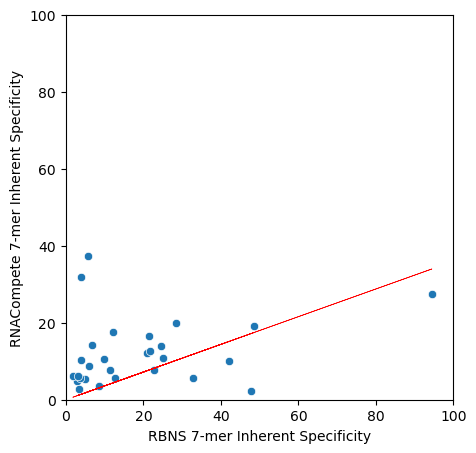

In [110]:
## Compare RBNS and RNCMPT
################################################################################
RBNS_v_RNCMPT = pd.read_table(baseDir + 'RNACompete/RBNS_v_RNCMPT.txt')
# RBNS_v_RNCMPT['IS_RBNS_rank'] = RBNS_v_RNCMPT.IS_RBNS.rank(ascending = False, method = 'dense').astype(int)
# RBNS_v_RNCMPT['IS_RNCMPT_rank'] = RBNS_v_RNCMPT.IS_RNCMPT.rank(ascending = False, method = 'dense').astype(int)

pearson_corr, pearson_pval = pearsonr(RBNS_v_RNCMPT.IS_RBNS, RBNS_v_RNCMPT.IS_RNCMPT)
spearman_corr, spearman_pval = spearmanr(RBNS_v_RNCMPT.IS_RBNS, RBNS_v_RNCMPT.IS_RNCMPT)

slope = np.sum(RBNS_v_RNCMPT.IS_RBNS * RBNS_v_RNCMPT.IS_RNCMPT) / np.sum(RBNS_v_RNCMPT.IS_RBNS**2)
reg_x = np.array(RBNS_v_RNCMPT.IS_RBNS)
reg_y = slope*reg_x

plt.figure(figsize = (5, 5))
sns.scatterplot(data = RBNS_v_RNCMPT, x = 'IS_RBNS', y = 'IS_RNCMPT')
plt.plot(reg_x, reg_y, color = 'red', lw = 0.5)
plt.xlabel('RBNS 7-mer Inherent Specificity'); plt.ylabel('RNACompete 7-mer Inherent Specificity')
plt.xlim(0, 100); plt.ylim(0, 100)
# plt.xscale('log'); plt.yscale('log')
plt.show()


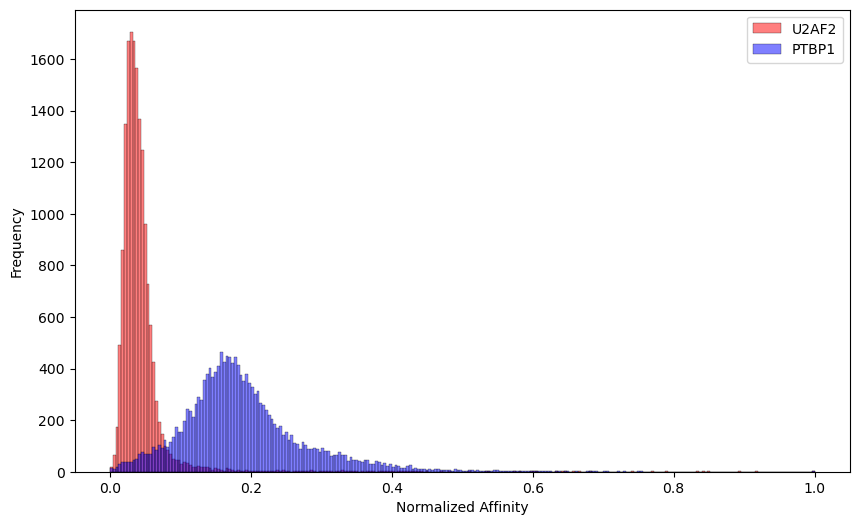

In [48]:
## Visualize normalized affinity distributions
################################################################################

plt.figure(figsize = (10, 6))
sns.histplot(RNCMPT_norm.HNRNPCL1, kde = False, color = 'red', alpha = 0.5, label = 'U2AF2', bins = 250)
sns.histplot(RNCMPT_norm.PCBP1, kde = False, color = 'blue', alpha = 0.5, label = 'PTBP1', bins = 250)
plt.xlabel('Normalized Affinity')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
## Process Target RNA Data
################################################################################
RNA_List = ['PTBP2', 'MAT2A', 'MIRLET7A2', 'MALAT1', 'CD55', 'PCBP2', 'NF1', 'PAPD4', 'C4BPB', 'MYL6', 'MYC', 'NUP133']
RNA_Targets = pd.DataFrame(map(lambda name: processFASTA(baseDir, name), RNA_List), columns=['chr', 'length', 'name', 'sequence'])


In [124]:
RNA_Targets

,chr,length,name,sequence
0,chr1,2725,PTBP2,UCAACCGGGAGAGUGUUGUGUUGAAGGAACUUGUAUUCAUUUUAAU...
1,chr2,1634,MAT2A,GGAUCCUGAUGCCAAAGUAGCUUGUGGUAGGUUCAGAAUGUGCUUA...
2,chr11,2183,MIRLET7A2,UGUGCCAUCUACUCGCCAUUGCAGAUAAUACCAGAUUGGCAAAGGU...
3,chr11,7183,MALAT1,CGAAUUCCGGUGAUGCGAGUUGUUCUCCGUCUAUAAAUACGCCUCG...
4,chr1,3929,CD55,GCUAGCAAAUCAAUGACUUUAACAAAUUUUUGUUGUUAAUCCUUUU...
5,chr12,1952,PCBP2,GGGCAAGUGCUGUUGCUUUUCUAUUCCCACACCCAAAAGGCAUUCA...
6,chr17,4407,NF1,UAAUUACAGGGCUCGUCCAACUGGUCCCUCAGUCACACAUGCCAGA...
7,chr5,2436,PAPD4,AAUACUUCAGGCUUUGCCACUCACAUAUUGUUUGUUGCAUAUUUUU...
8,chr1,2308,C4BPB,CCACAGGAUCCCUGUCUUUUUAUGUCACUUCAUUAUCUAAAUCUAG...
9,chr12,2298,MYL6,ACUGUAGCUAUACCCUCUGGAAGUUCUCUUUAUACUGGAGGGGUGC...


In [8]:
## Set up query RNA:
################################################################################
# query:          RNA sequence to test.
# L:              length of the query sequence.
# K:              K-mer
# W:              number of possible K-mers in the query sequence.
# query_W:        all possible K-mers within the query sequence.
# unique_query_W: all unique K-mers within the query sequence.

K = 7

RNA_Target = 'PTBP2'
# query = RNA_Targets[RNA_Targets.name == RNA_Target].sequence.values[0]
# L = RNA_Targets[RNA_Targets.name == RNA_Target].length.values[0]

query = 'TCATCCATAACGAAGGGTGGTTCCCGCAGAATGGTGAGGTGGTCATGGATCATGGTTCAAGGCGGTTAATTGGGGCAAGTTGGTCCGAGGAACATTTGTTCAAGCACAGAAGCATGAACATAGGGAATGGAGACAGGGAATGAAGACAAGGACAAGGAAAATAAAGGATAAGACAGGGAAGGGAATGGGCATTTGGGAAAAGACAAGGAAAGGGAAGGTGAACACACAGGGAAAAGGATGAAATGGGGAAGGGAAACAGCAATGCAGAAGAAAAAAATAAGGAATTGGGGAACAAAAACAAAATAAAATATAGGTCAGTACATAGGAAATGCAGGAATTTGGTCAGAAAATGGTTGGTTTATGTACTGTACAAGAAAAACTGAGTAAAATGTAGTCATCCA'
query = query[201:400]
query = query.replace('T', 'U')
L = len(query)

# L = len(query)
W = L - K + 1

query_W = [query[i:i+K] for i in range(W)]

unique_query_W = pd.DataFrame({'motif': list(set(query_W))})
unique_query_W['cnt'] = unique_query_W['motif'].apply(lambda x: query_W.count(x))


In [9]:
## Set up RBP:
################################################################################
U2AF2_KaH = 100
U2AF2_KaL = 1

PTBP1_KaH = 100
PTBP1_KaL = 1

RBP_Ka = pd.DataFrame({
    'Motif': RNCMPT_norm.Motif,
    'U2AF2': RNCMPT_norm.U2AF2,
    'PTBP1': RNCMPT_norm.PTBP1
})
RBP_Ka.U2AF2 = featureScale(RBP_Ka.U2AF2, MAX=U2AF2_KaH, MIN=U2AF2_KaL)
RBP_Ka.PTBP1 = featureScale(RBP_Ka.PTBP1, MAX=PTBP1_KaH, MIN=PTBP1_KaL)

In [41]:
## Set up simulation for U2AF2:
################################################################################
N = 1
U2AF20 = 500

P0 = [U2AF20]
R0 = 100

U2AF2 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.U2AF2,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'U2AF2Req': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_U2AF2 = U2AF2.loc[U2AF2.motif == window, 'Kd'].values[0]

  Kd = [Kd_U2AF2]
  Req = allBind(N, eR0, P0, Kd)
  
  U2AF2Req = (U2AF20 * Req)/(Kd_U2AF2 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'U2AF2Req'] = U2AF2Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'U2AF2Req': np.zeros(L),
    'U2AF2/U2AF20': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] = simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] + simulation.U2AF2Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['U2AF2Req'] = simulation_per_pos['U2AF2Req'] / np.maximum(update_counts, 1)


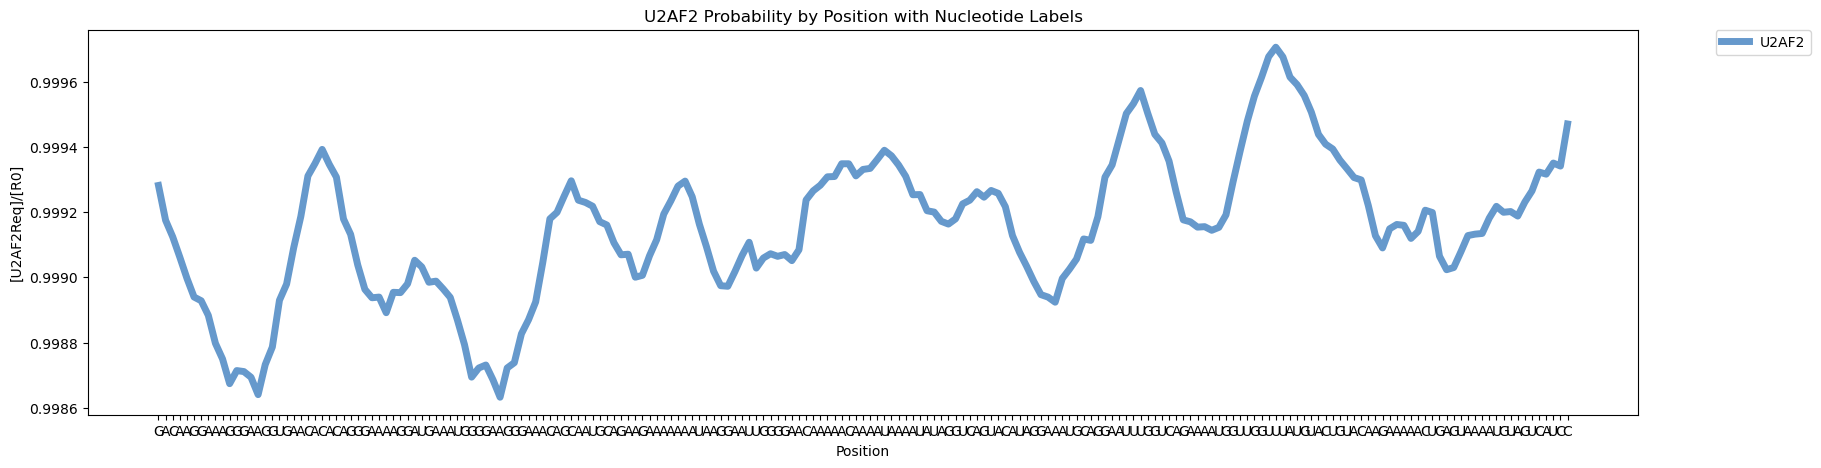

In [42]:
## Plot per position values for U2AF2:

plot_data_U2AF2 = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'U2AF2Req': simulation_per_pos.U2AF2Req/R0,
})

plot_data_U2AF2 = plot_data_U2AF2.melt(id_vars='pos', value_vars=['U2AF2Req'], var_name='variable', value_name='value')

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data_U2AF2, x='pos', y='value', color = '#6699CC', label = 'U2AF2', lw = 5)

# plt.ylim(0, 0.02)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('[U2AF2Req]/[R0]')
plt.title('U2AF2 Probability by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [39]:
## Set up simulation for PTBP1:
################################################################################
N = 1
PTBP10 = 500

P0 = [PTBP10]
R0 = 100

PTBP1 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.PTBP1,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'PTBP1Req': [None] * W
   })

## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  Kd_PTBP1 = PTBP1.loc[PTBP1.motif == window, 'Kd'].values[0]

  Kd = [Kd_PTBP1]
  Req = allBind(N, eR0, P0, Kd)
  
  PTBP1Req = (PTBP10 * Req)/(Kd_PTBP1 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'PTBP1Req'] = PTBP1Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'PTBP1Req': np.zeros(L),
    'PTBP1/PTBP10': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] = simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] + simulation.PTBP1Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['PTBP1Req'] = simulation_per_pos['PTBP1Req'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['PTBP1/R0'] = (simulation_per_pos['PTBP1Req'])/R0


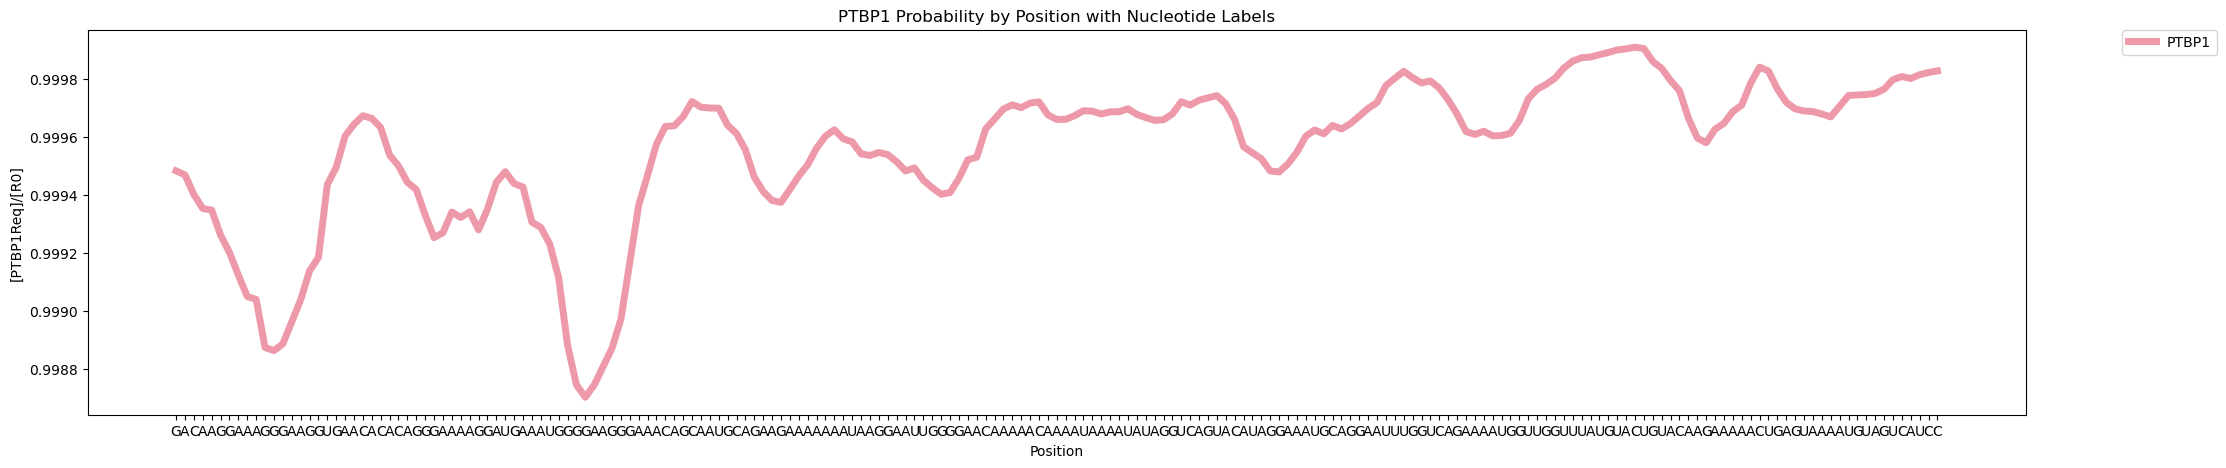

In [40]:
## Plot per position values for PTBP1:

plot_data_PTBP1 = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'PTBP1Req': simulation_per_pos.PTBP1Req/R0,
})

plot_data_PTBP1 = plot_data_PTBP1.melt(id_vars='pos', value_vars=['PTBP1Req'], var_name='variable', value_name='value')

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data_PTBP1, x='pos', y='value', color = '#EE99AA', label = 'PTBP1', lw = 5)

# plt.ylim(0, 0.02)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('[PTBP1Req]/[R0]')
plt.title('PTBP1 Probability by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


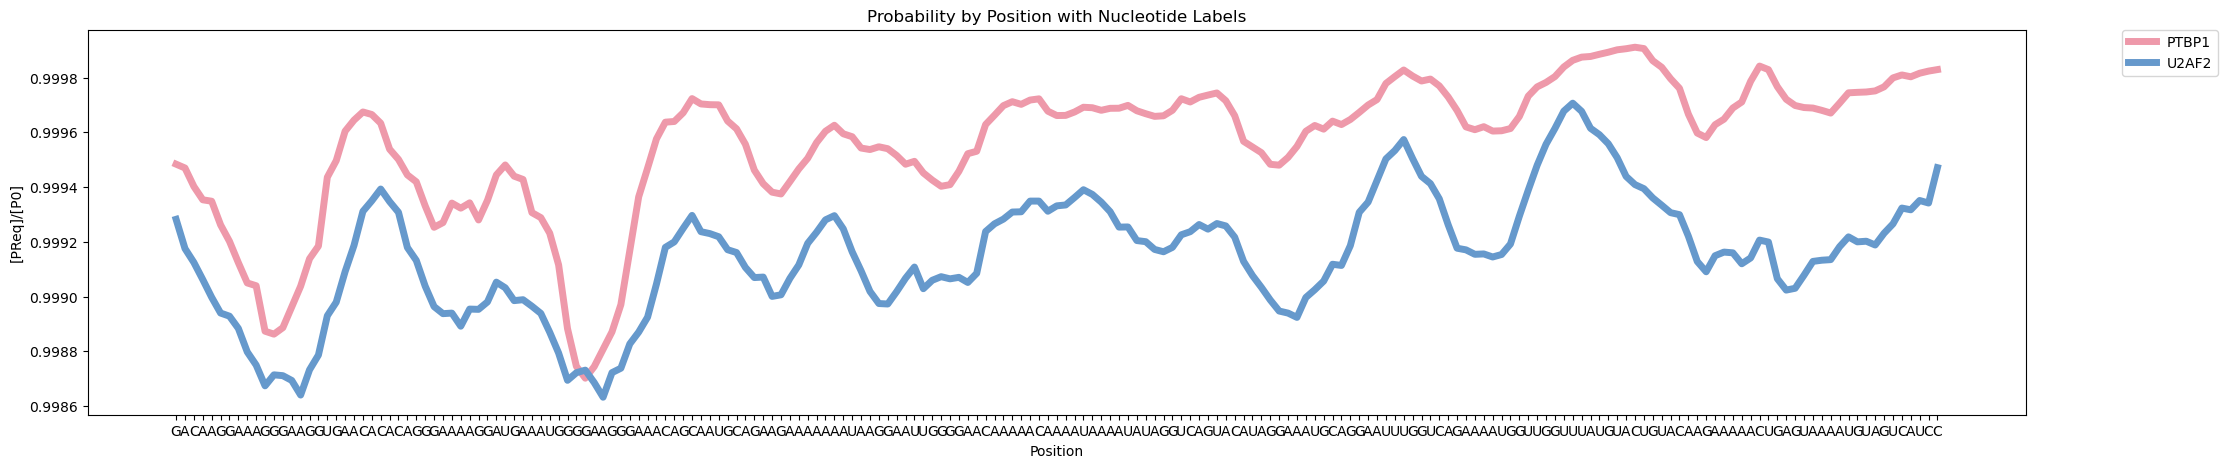

In [43]:
## Single RBP Plots Overlap

plt.figure(figsize=(25, 5))
sns.lineplot(data=plot_data_PTBP1, x='pos', y='value', color = '#EE99AA', label = 'PTBP1', lw = 5)
sns.lineplot(data=plot_data_U2AF2, x='pos', y='value', color = '#6699CC', label = 'U2AF2', lw = 5)

# plt.ylim(0, 0.02)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('[PReq]/[P0]')
plt.title('Probability by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()


In [50]:
## Set up simulation for U2AF2 and PTBP1:
################################################################################
N = 2
U2AF20 = 500
PTBP10 = 250

P0 = [U2AF20, PTBP10]
R0 = 100

U2AF2 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.U2AF2,
   })


PTBP1 = pd.DataFrame({
   'motif': RBP_Ka.Motif,
   'Kd': 1/RBP_Ka.PTBP1,
   })

simulation = pd.DataFrame({
   'win_num': range(W),
   'motif': query_W,
   'Req': [None] * W,
   'U2AF2Req': [None] * W,
   'PTBP1Req': [None] * W
   })


## Loop through each window:
for idx in range(len(unique_query_W)):
  window = unique_query_W.loc[idx, 'motif']
  appearance = unique_query_W.loc[idx, 'cnt']
  eR0 = R0 * appearance
  
  Kd_U2AF2 = U2AF2.loc[U2AF2.motif == window, 'Kd'].values[0]
  Kd_PTBP1 = PTBP1.loc[PTBP1.motif == window, 'Kd'].values[0]

  Kd = [Kd_U2AF2, Kd_PTBP1]
  Req = allBind(N, eR0, P0, Kd)
  
  U2AF2Req = (U2AF20 * Req)/(Kd_U2AF2 + Req)
  PTBP1Req = (PTBP10 * Req)/(Kd_PTBP1 + Req)
 
  simulation.loc[simulation.motif == window, 'Req'] = Req/appearance
  simulation.loc[simulation.motif == window, 'U2AF2Req'] = U2AF2Req/appearance
  simulation.loc[simulation.motif == window, 'PTBP1Req'] = PTBP1Req/appearance

simulation = simulation.sort_values(by = ["win_num"])

## Calculate per position values:
simulation_per_pos = pd.DataFrame({
    'pos': range(L),
    'nt': list(query),
    'Req': np.zeros(L),
    'U2AF2Req': np.zeros(L),
    'U2AF2/U2AF20': np.zeros(L),
    'PTBP1Req': np.zeros(L),
    'PTBP1/PTBP10': np.zeros(L)
})
update_counts = np.zeros(L)

for idx in range(W):
    update_counts[idx:idx+K] += 1
    simulation_per_pos.loc[idx:idx+K-1, 'Req'] = simulation_per_pos.loc[idx:idx+K-1, 'Req'] + simulation.Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] = simulation_per_pos.loc[idx:idx+K-1, 'U2AF2Req'] + simulation.U2AF2Req[idx]
    simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] = simulation_per_pos.loc[idx:idx+K-1, 'PTBP1Req'] + simulation.PTBP1Req[idx]

simulation_per_pos['Req'] = simulation_per_pos['Req'] / np.maximum(update_counts, 1)
simulation_per_pos['U2AF2Req'] = simulation_per_pos['U2AF2Req'] / np.maximum(update_counts, 1)
simulation_per_pos['PTBP1Req'] = simulation_per_pos['PTBP1Req'] / np.maximum(update_counts, 1)

## Calculate and normalize probability:
simulation_per_pos['U2AF2/R0'] = (simulation_per_pos['U2AF2Req'])/R0
simulation_per_pos['PTBP1/R0'] = (simulation_per_pos['PTBP1Req'])/R0


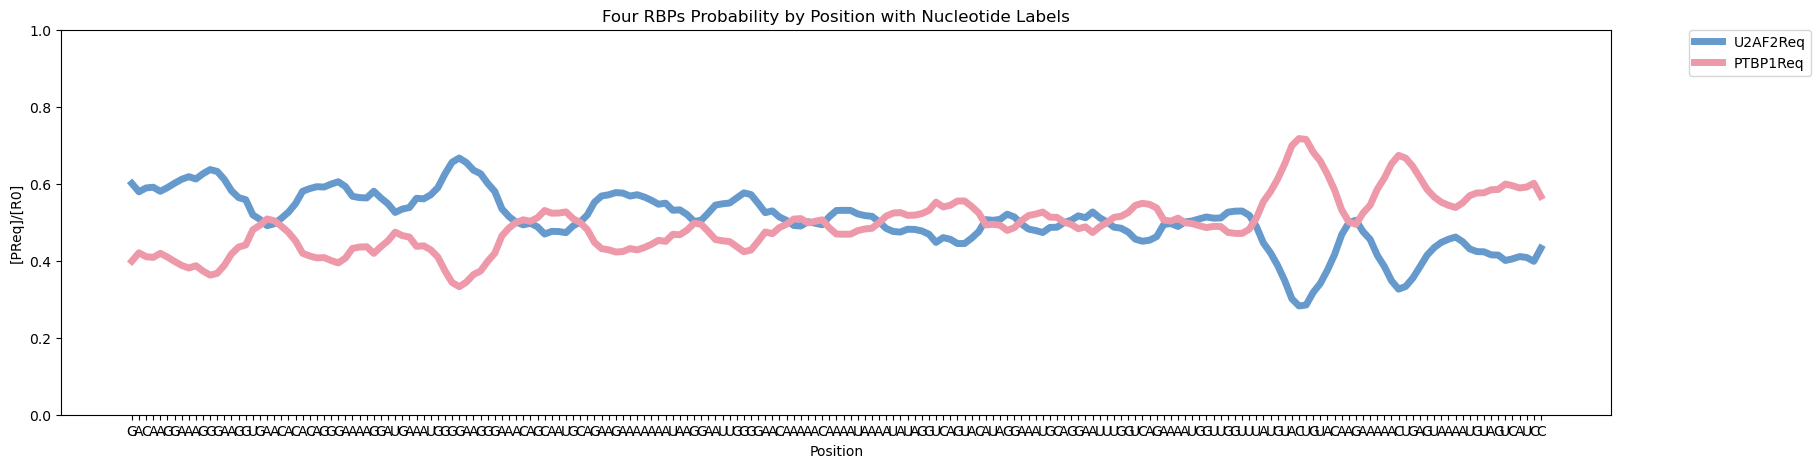

In [54]:
## Plot per position values for U2AF2 and PTBP1:

plot_data = pd.DataFrame({
    'pos': simulation_per_pos.pos,
    'U2AF2Req': simulation_per_pos.U2AF2Req/(R0),
    'PTBP1Req': simulation_per_pos.PTBP1Req/(R0),
    # 'combined': (simulation_per_pos.U2AF2Req/(R0) - simulation_per_pos.PTBP1Req/(R0))
})

plot_data = plot_data.melt(id_vars='pos', value_vars=['U2AF2Req', 'PTBP1Req'], var_name='variable', value_name='value')
plot_color = {'U2AF2Req': '#6699CC', 'PTBP1Req': '#EE99AA'}

plt.figure(figsize=(20, 5))
sns.lineplot(data=plot_data, x='pos', y='value', hue='variable', palette = plot_color, lw = 5)

plt.ylim(0, 1)
plt.xticks(simulation_per_pos['pos'], simulation_per_pos['nt'])

plt.xlabel('Position')
plt.ylabel('[PReq]/[R0]')
plt.title('Four RBPs Probability by Position with Nucleotide Labels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()